In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from xgboost.callback import EarlyStopping
from sklearn.model_selection import RandomizedSearchCV
from scipy.sparse import issparse
import shap


In [27]:
import pandas as pd

path_main = "../../data_processed/Chicago_Airbnb_Master_v4.csv"
path_nlp = "../../data_processed/listings_with_nlp_features.csv"

df_main = pd.read_csv(path_main)
df_nlp = pd.read_csv(path_nlp)


In [28]:
df_main

,listing_id,price,accommodates,bedrooms,bathrooms,room_type,property_type,review_scores_rating,occupancy_proxy,weekend_occupancy_proxy,...,is_premium_transit_hub,shoreline_gravity,dist_to_nearest_beach_miles,crime_density_total,nb_homicides_half_mile,neigh_log_competition,neigh_price_index,price_vs_neigh_median,distance_to_downtown_km,neigh_avg_occ
0,2384,119.0,1,1.0,1.0,Private room,Private room in condo,4.99,0.046575,0.048077,...,0.3697,0.5992,0.5271,390.6212,0,4.488636,0.714765,1.117371,10.608606,0.441002
1,7126,89.0,2,1.0,1.0,Entire home/apt,Entire rental unit,4.73,0.172603,0.182692,...,0.0000,0.2589,2.9792,314.0505,0,6.496775,1.077181,0.554517,4.934691,0.342197
2,10945,203.0,4,2.0,1.0,Entire home/apt,Entire rental unit,4.74,0.109589,0.115385,...,0.7038,0.5976,0.8182,253.4784,0,5.533389,1.362416,1.000000,3.851522,0.328517
3,12140,339.0,3,1.0,1.0,Private room,Room in boutique hotel,4.95,0.572603,0.605769,...,0.7350,0.5051,1.4270,253.4784,0,5.533389,1.362416,1.669951,5.307615,0.328517
4,28749,258.0,6,3.0,2.0,Entire home/apt,Entire loft,4.83,0.797260,0.807692,...,0.7260,0.2820,2.8707,258.2845,0,6.013715,0.869128,1.992278,6.243387,0.422636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7301,1513249755900649268,107.0,5,2.0,1.0,Entire home/apt,Entire rental unit,NaN,0.841096,0.846154,...,0.7669,0.1882,5.1224,226.8979,0,5.192957,0.798658,0.899160,9.816556,0.385597
7302,1513310607821260198,319.0,10,4.0,2.0,Entire home/apt,Entire rental unit,NaN,0.005479,0.019231,...,0.5909,0.3324,2.8125,383.6329,1,6.220590,1.348993,1.587065,2.126220,0.322780
7303,1513409535347783812,178.0,2,1.0,1.0,Entire home/apt,Entire rental unit,NaN,0.268493,0.269231,...,0.0000,0.7452,1.1267,253.4784,0,5.533389,1.362416,0.876847,5.537772,0.328517
7304,1513821766801636584,900.0,4,2.0,1.0,Entire home/apt,Entire rental unit,NaN,0.246575,0.240385,...,0.7602,0.6000,1.6778,365.3628,0,6.184149,1.083893,5.572755,6.237332,0.409097


In [29]:
df_nlp

,id,description,tokens_final,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7
0,2384,Solo Hyde Park visitors are invited to enjoy t...,"['solo', 'hyde_park', 'visitor', 'invite', 'vi...",0.048142,0.003915,0.612545,0.003908,0.120481,0.155415,0.051686,0.003908
1,7126,A very small studio in a wonderful neighborhood.,"['small', 'studio', 'wonderful', 'neighborhood']",0.025038,0.025006,0.463507,0.025049,0.025049,0.025038,0.025036,0.386278
2,10945,Beautiful first floor apartment in Historic Ol...,"['beautiful', 'first_floor', 'historic', 'old_...",0.380655,0.005011,0.496929,0.097378,0.005006,0.005010,0.005006,0.005005
3,12140,Bed and Breakfast license issued by the City o...,"['bed', 'breakfast', 'license', 'issue', 'city']",0.020894,0.020884,0.020868,0.020861,0.020873,0.527471,0.020880,0.347268
4,28749,Located on a peaceful treelined street in ener...,"['locate', 'peaceful', 'treeline', 'street', '...",0.003688,0.003686,0.117849,0.003682,0.089180,0.159832,0.618390,0.003692
...,...,...,...,...,...,...,...,...,...,...,...
8493,1513821766801636584,*Only available for stays of 32 nights and lon...,"['available', 'night', 'long', 'sunny', 'cozy'...",0.005220,0.476386,0.492310,0.005219,0.005212,0.005215,0.005221,0.005216
8494,1514427498735918146,You'll have a great time at this comfortable p...,"['great_time', 'comfortable']",0.041712,0.041701,0.708082,0.041710,0.041669,0.041677,0.041773,0.041677
8495,1514602729230425948,Large Group Getaway | Two Full Units Combined ...,"['large_group', 'getaway', 'two', 'full', 'uni...",0.002980,0.085650,0.002983,0.029906,0.002980,0.719687,0.152833,0.002980
8496,1514621681093690520,Perfect Pair | Units 1 & 2 Combined for Medium...,"['pair', 'unit', 'combine', 'medium', 'group',...",0.110073,0.114788,0.002724,0.025620,0.002721,0.653963,0.061339,0.028772


In [30]:
#Data Merging
df = pd.merge(df_main, df_nlp, left_on='listing_id', right_on='id', how='left')

In [31]:
print(df.shape)
print(df.columns)
df.isna().mean().sort_values(ascending=False)


(7306, 82)
Index(['listing_id', 'price', 'accommodates', 'bedrooms', 'bathrooms',
       'room_type', 'property_type', 'review_scores_rating', 'occupancy_proxy',
       'weekend_occupancy_proxy', 'summer_occupancy_proxy',
       'winter_occupancy_proxy', 'total_review_count', 'recent_review_count',
       'avg_review_length', 'estimated_annual_revenue', 'log_revenue',
       'host_is_superhost', 'host_listings_count', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'latitude', 'longitude', 'beds',
       'minimum_nights', 'maximum_nights', 'has_availability',
       'availability_30', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'number_of_reviews_ly', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable',
      

review_scores_rating    0.173008
topic_7                 0.019710
topic_3                 0.019710
id                      0.019710
tokens_final            0.019710
                          ...   
has_availability        0.000000
maximum_nights          0.000000
minimum_nights          0.000000
beds                    0.000000
instant_bookable        0.000000
Length: 82, dtype: float64

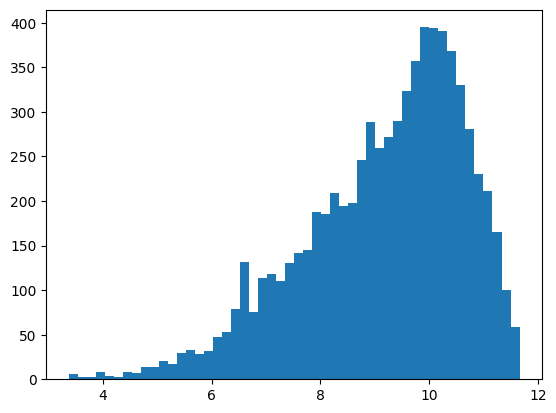

In [32]:
plt.hist(df["log_revenue"], bins=50)
plt.show()


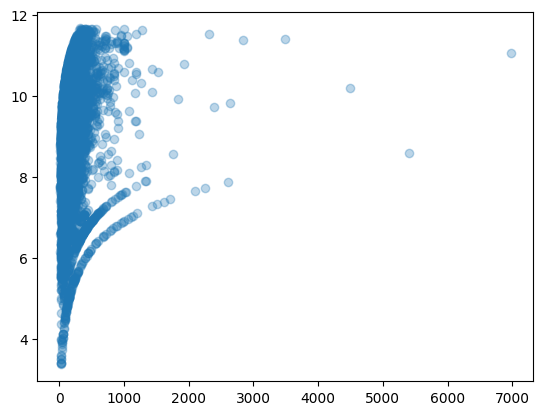

In [33]:
plt.scatter(df["price"], df["log_revenue"], alpha=0.3)
plt.show()


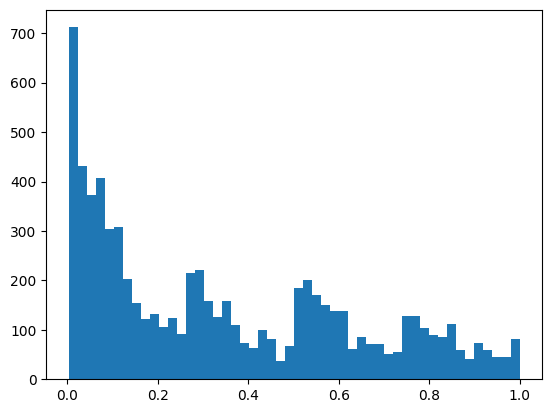

In [34]:
plt.hist(df["occupancy_proxy"], bins=50)
plt.show()


In [35]:
df.describe()


,listing_id,price,accommodates,bedrooms,bathrooms,review_scores_rating,occupancy_proxy,weekend_occupancy_proxy,summer_occupancy_proxy,winter_occupancy_proxy,...,neigh_avg_occ,id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7
count,7.306000e+03,7306.000000,7306.000000,7300.000000,7304.000000,6042.000000,7306.000000,7306.000000,7306.000000,7306.000000,...,7306.000000,7.162000e+03,7162.000000,7162.000000,7162.000000,7162.000000,7162.000000,7162.000000,7162.000000,7162.000000
mean,7.476653e+17,192.348754,4.437996,1.822466,1.416963,4.772069,0.343329,0.352250,0.420503,0.221267,...,0.343329,7.451251e+17,0.165112,0.091418,0.263891,0.086182,0.114397,0.083481,0.149794,0.045724
std,5.641979e+17,209.686116,3.057478,1.242813,0.789487,0.398191,0.290471,0.291622,0.457016,0.346163,...,0.057018,5.649372e+17,0.211973,0.177477,0.270261,0.238145,0.192532,0.154955,0.216043,0.130579
min,2.384000e+03,13.000000,1.000000,0.000000,0.000000,1.000000,0.002740,0.000000,0.000000,0.000000,...,0.002740,2.384000e+03,0.001648,0.001424,0.001565,0.001421,0.001422,0.001546,0.001422,0.001422
25%,4.867521e+07,95.000000,2.000000,1.000000,1.000000,4.730000,0.079452,0.086538,0.000000,0.000000,...,0.312815,4.864455e+07,0.005006,0.003911,0.007367,0.003476,0.004040,0.003799,0.004042,0.003575
50%,8.831434e+17,149.000000,4.000000,2.000000,1.000000,4.870000,0.279452,0.288462,0.054348,0.000000,...,0.342197,8.762577e+17,0.041732,0.008334,0.195573,0.004317,0.010904,0.007816,0.012512,0.005002
75%,1.263134e+18,229.000000,6.000000,2.000000,2.000000,4.970000,0.567123,0.576923,1.000000,0.322222,...,0.377008,1.267553e+18,0.280779,0.095924,0.468663,0.017860,0.150397,0.101446,0.234634,0.025017
max,1.514812e+18,6977.000000,16.000000,20.000000,17.000000,5.000000,1.000000,1.000000,1.000000,1.000000,...,0.541292,1.514812e+18,0.979142,0.977536,0.977514,0.953934,0.976953,0.976942,0.976334,0.977543


In [36]:
df.dtypes


listing_id        int64
price           float64
accommodates      int64
bedrooms        float64
bathrooms       float64
                 ...   
topic_3         float64
topic_4         float64
topic_5         float64
topic_6         float64
topic_7         float64
Length: 82, dtype: object

In [46]:
# Random Forest Regressor (cleaner baseline model)

y = df["log_revenue"]

exclude_cols = [
    "listing_id",
    "estimated_annual_revenue",
    "log_revenue",
    "occupancy_proxy",
    "weekend_occupancy_proxy",
    "winter_occupancy_proxy",
    "summer_occupancy_proxy",
    "neigh_avg_occ",
    "availability_30",
    "availability_365",
    "id",
    "description",
    "tokens_final",

    # drop duplicate pre-encoded columns
    "room_type_Hotel room",
    "room_type_Private room",
    "room_type_Shared room",
    "property_type_clean_Entire home",
    "property_type_clean_Entire rental unit",
    "property_type_clean_Other",
    "property_type_clean_Private room in home",
    "property_type_clean_Private room in rental unit",
]
X = df.drop(columns=exclude_cols)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

cat_cols = ["room_type", "property_type", "neighbourhood_cleansed", "instant_bookable"]
num_cols = [c for c in X.columns if c not in cat_cols]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", rf)
])

model.fit(X_train, y_train)

preds = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE:", rmse)

from sklearn.metrics import r2_score

r2 = r2_score(y_test, preds)
print("R-squared:", r2)



RMSE: 1.1145067176204033
R-squared: 0.41613825041109964


In [38]:
feature_importances = model.named_steps["model"].feature_importances_

feature_names = model.named_steps["preprocess"].get_feature_names_out()

importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": feature_importances
}).sort_values("importance", ascending=False)

importance_df.head(15)


,feature,importance
0,num__price,0.163387
10,num__host_total_listings_count,0.060937
56,num__topic_7,0.038338
17,num__maximum_nights,0.036279
31,num__Amenity_PCA_1,0.030299
51,num__topic_2,0.027654
34,num__Amenity_PCA_4,0.026679
47,num__price_vs_neigh_median,0.023834
32,num__Amenity_PCA_2,0.022933
35,num__Amenity_PCA_5,0.022527


                           feature  importance
0                       num__price    0.163387
10  num__host_total_listings_count    0.060937
56                    num__topic_7    0.038338
17             num__maximum_nights    0.036279
31              num__Amenity_PCA_1    0.030299
51                    num__topic_2    0.027654
34              num__Amenity_PCA_4    0.026679
47      num__price_vs_neigh_median    0.023834
32              num__Amenity_PCA_2    0.022933
35              num__Amenity_PCA_5    0.022527


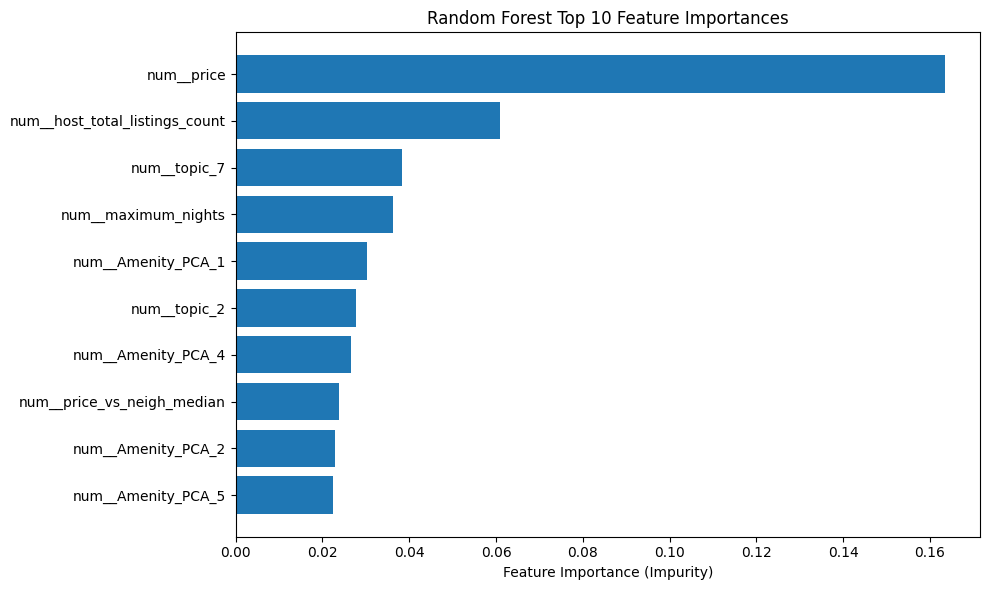

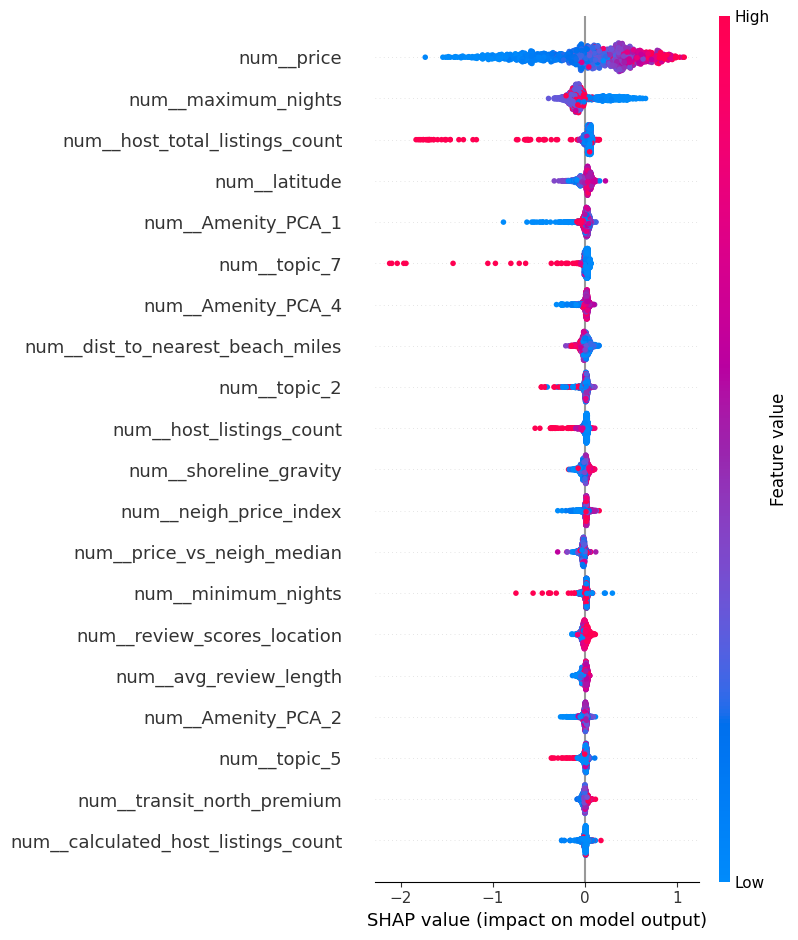

In [39]:
# ── 1. Feature Importance ──────────────────────────────────────────
feature_importances = model.named_steps["model"].feature_importances_
feature_names = model.named_steps["preprocess"].get_feature_names_out()

importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": feature_importances
}).sort_values("importance", ascending=False)

print(importance_df.head(10))

plt.figure(figsize=(10, 6))
plt.barh(
    importance_df["feature"].head(10)[::-1],
    importance_df["importance"].head(10)[::-1]
)
plt.xlabel("Feature Importance (Impurity)")
plt.title("Random Forest Top 10 Feature Importances")
plt.tight_layout()
plt.show()

# ── 2. SHAP ────────────────────────────────────────────────────────
Xt = model.named_steps["preprocess"].transform(X_test)
if issparse(Xt):
    Xt_dense = Xt.toarray().astype(float)
else:
    Xt_dense = Xt.astype(float)

rf_model = model.named_steps["model"]
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(Xt_dense)

shap.summary_plot(shap_values, Xt_dense, feature_names=feature_names)


In [44]:
y = df["log_revenue"]

exclude_cols = [
    "listing_id",
    "estimated_annual_revenue",
    "log_revenue",
    "occupancy_proxy",
    "weekend_occupancy_proxy",
    "winter_occupancy_proxy",
    "summer_occupancy_proxy",
    "neigh_avg_occ",
    "availability_30",
    "availability_365",
    "id",
    "description",
    "tokens_final",

    # drop duplicate pre-encoded columns
    "room_type_Hotel room",
    "room_type_Private room",
    "room_type_Shared room",
    "property_type_clean_Entire home",
    "property_type_clean_Entire rental unit",
    "property_type_clean_Other",
    "property_type_clean_Private room in home",
    "property_type_clean_Private room in rental unit",
]

X = df.drop(columns=exclude_cols)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

cat_cols = ["room_type", "property_type", "neighbourhood_cleansed", "instant_bookable"]
num_cols = [c for c in X.columns if c not in cat_cols]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

xgb = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1,
)

model_xgb = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", xgb)
])

param_dist = {
    "model__n_estimators": [200, 300, 500],
    "model__learning_rate": [0.01, 0.05, 0.1],
    "model__max_depth": [3, 4, 5],
    "model__subsample": [0.7, 0.8, 1.0],
    "model__colsample_bytree": [0.7, 0.8, 1.0],
    "model__reg_lambda": [0.5, 1.0, 2.0],
}

search = RandomizedSearchCV(
    model_xgb,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring="neg_root_mean_squared_error",
    random_state=42,
    n_jobs=-1,
    verbose=1,
)

search.fit(X_train, y_train)

print("Best params:", search.best_params_)
preds = search.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE:", rmse)

from sklearn.metrics import r2_score

r2 = r2_score(y_test, preds)
print("R-squared:", r2)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best params: {'model__subsample': 0.8, 'model__reg_lambda': 1.0, 'model__n_estimators': 300, 'model__max_depth': 5, 'model__learning_rate': 0.05, 'model__colsample_bytree': 0.7}
RMSE: 1.1194202983431014
R-squared: 0.41097870167743256


In [41]:
best_model_xgb = search.best_estimator_

X_test_transformed = best_model_xgb[:-1].transform(X_test)
if issparse(X_test_transformed):
    X_test_transformed = X_test_transformed.toarray()

feature_names = best_model_xgb.named_steps["preprocess"].get_feature_names_out()

feature_importances_xgb = best_model_xgb.named_steps["model"].feature_importances_

importance_df_xgb = pd.DataFrame({
    "feature": feature_names,
    "importance": feature_importances_xgb
}).sort_values("importance", ascending=False)

print(importance_df_xgb.head(15))


                                          feature  importance
57                 cat__room_type_Entire home/apt    0.052705
10                 num__host_total_listings_count    0.032197
0                                      num__price    0.023007
17                            num__maximum_nights    0.019662
94               cat__property_type_Room in hotel    0.017874
59                    cat__room_type_Private room    0.016325
149   cat__neighbourhood_cleansed_Near South Side    0.014732
46                         num__neigh_price_index    0.013705
56                                   num__topic_7    0.013583
45                     num__neigh_log_competition    0.013142
142              cat__neighbourhood_cleansed_Loop    0.012984
9                        num__host_listings_count    0.012872
29            num__calculated_host_listings_count    0.012632
141      cat__neighbourhood_cleansed_Logan Square    0.012174
71   cat__property_type_Entire serviced apartment    0.011724


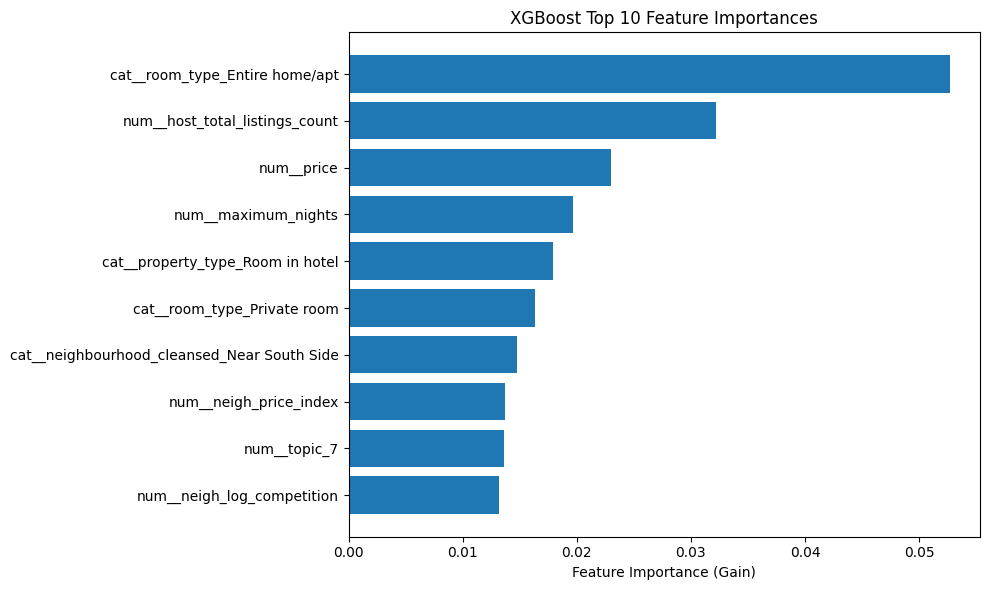

In [42]:
plt.figure(figsize=(10, 6))
plt.barh(
    importance_df_xgb["feature"].head(10)[::-1],
    importance_df_xgb["importance"].head(10)[::-1]
)
plt.xlabel("Feature Importance (Gain)")
plt.title("XGBoost Top 10 Feature Importances")
plt.tight_layout()
plt.show()


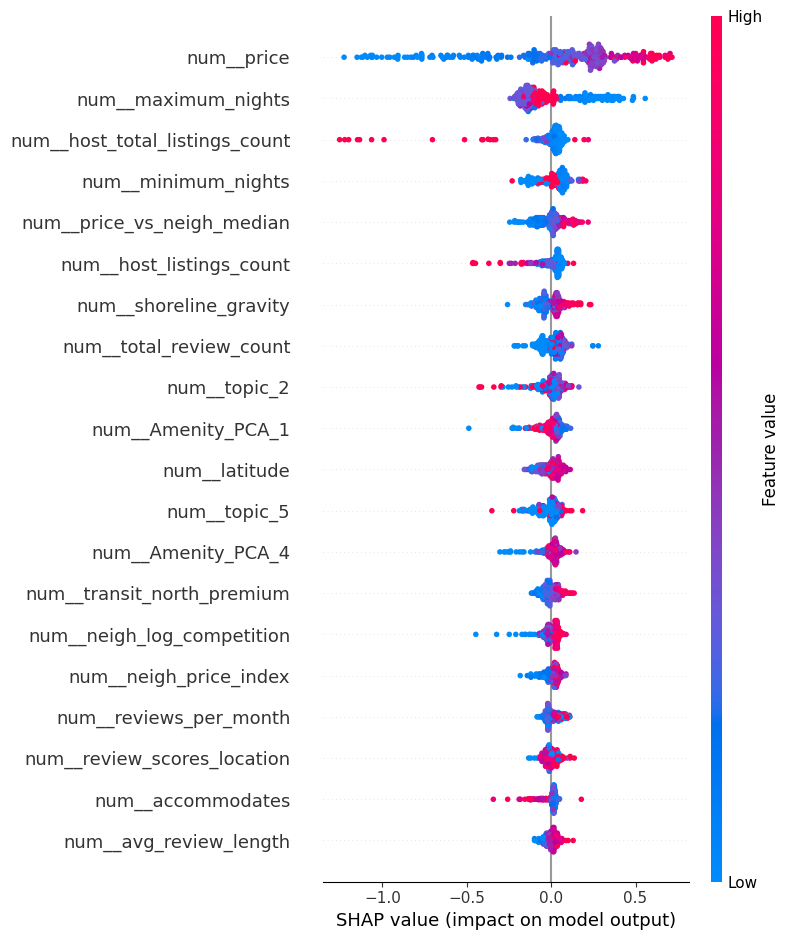

In [43]:
# ── XGBoost SHAP ──────────────────────────────────────────────────
best_model_xgb = search.best_estimator_

X_test_transformed = best_model_xgb[:-1].transform(X_test)
if issparse(X_test_transformed):
    X_test_transformed = X_test_transformed.toarray().astype(float)
else:
    X_test_transformed = X_test_transformed.astype(float)

feature_names = best_model_xgb.named_steps["preprocess"].get_feature_names_out()
xgb_model = best_model_xgb.named_steps["model"]

# sample for faster SHAP
sample_size = min(300, X_test_transformed.shape[0])
sample_idx = np.random.RandomState(42).choice(
    X_test_transformed.shape[0],
    sample_size,
    replace=False
)
X_sample = X_test_transformed[sample_idx]

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_sample)

shap.summary_plot(shap_values, X_sample, feature_names=feature_names)


## Advanced Revenue Modeling Summary

In this notebook, I extended the original revenue modeling workflow by using the merged v4 dataset, which includes more advanced features beyond the base version. These added features include:

- host-related features
- neighborhood and geospatial features
- amenity PCA features
- market positioning features such as `price_vs_neigh_median` and `neigh_price_index`
- NLP topic features from listing descriptions

### What I did

- Started with the merged dataset and checked the shape, columns, and missing values.
- Kept the same general modeling idea as the base notebook so the results would still be comparable.
- Used `log_revenue` as the prediction target.
- Dropped columns that should not be used as predictors:
  - IDs like `listing_id` and `id`
  - direct target columns like `estimated_annual_revenue` and `log_revenue`
  - raw text columns like `description` and `tokens_final`
- Removed leakage-like variables that were too close to realized demand:
  - `occupancy_proxy`
  - `weekend_occupancy_proxy`
  - `summer_occupancy_proxy`
  - `winter_occupancy_proxy`
  - `availability_30`
  - `availability_365`
  - `neigh_avg_occ`
- Cleaned duplicate encoded features:
  - removed already one-hot encoded room/property columns
  - kept the original categorical variables such as `room_type`, `property_type`, `neighbourhood_cleansed`, and `instant_bookable`
  - encoded those properly in the modeling pipeline
- Trained two models on the cleaned feature set:
  - Random Forest
  - XGBoost with hyperparameter tuning using `RandomizedSearchCV`
- Compared model performance using:
  - RMSE
  - R-squared
- Examined feature importance for both models
- Used SHAP to better understand feature effects, especially for XGBoost

### Model performance

- **Random Forest**
  - RMSE: `1.1145`
  - R-squared: `0.4161`

- **XGBoost**
  - RMSE: `1.1194`
  - R-squared: `0.4110`

### How I interpret the performance

- The two models performed very similarly.
- Random Forest was slightly better than XGBoost on both RMSE and R-squared.
- This is completely fine. XGBoost is not always better just because it is more advanced.
- An R-squared around `0.41` means the model explains about 41% of the variation in `log_revenue`.
- That is not extremely high, but it is reasonable for this kind of Airbnb revenue problem, where a lot of revenue variation is affected by things we do not fully observe, like seasonality, local events, host behavior, dynamic pricing, and market demand shifts.
- So this model is usable for **directional insight and feature interpretation**, but not for exact revenue forecasting.

### Random Forest results

Top features from Random Forest included:

- `price`
- `host_total_listings_count`
- `topic_7`
- `maximum_nights`
- `Amenity_PCA_1`
- `topic_2`
- `Amenity_PCA_4`
- `price_vs_neigh_median`
- `Amenity_PCA_2`
- `Amenity_PCA_5`
- `latitude`

### How I interpret the Random Forest results

- `price` being the top feature makes sense because pricing is one of the most direct drivers of revenue.
- `host_total_listings_count` suggests that larger or more experienced hosts may perform better.
- `maximum_nights` may reflect listing strategy and what kind of guests the property is targeting.
- `price_vs_neigh_median` shows that relative pricing within the local market matters, not just absolute price.
- The `Amenity_PCA` features suggest that the overall amenity package matters for revenue.
- The topic features mean that listing description content is capturing something real about how the property is positioned or presented.
- `latitude` suggests that location still matters even after adding other neighborhood features.

Overall, the Random Forest model suggests that revenue is influenced by a mix of:

- pricing strategy
- host scale/experience
- listing policies
- amenities
- location
- how the listing is described

### XGBoost results

Top features from XGBoost included:

- `room_type_Entire home/apt`
- `host_total_listings_count`
- `price`
- `maximum_nights`
- `property_type_Room in hotel`
- `room_type_Private room`
- `neigh_price_index`
- `topic_7`
- `neigh_log_competition`
- neighborhood indicators like `Near South Side`, `Loop`, and `Logan Square`

### How I interpret the XGBoost results

- XGBoost is putting more emphasis on market segmentation features like room type and neighborhood identity.
- `room_type_Entire home/apt` being very important suggests that the type of listing strongly affects revenue potential.
- `neigh_price_index` and `neigh_log_competition` show that local market context matters a lot.
- Specific neighborhood indicators suggest that some neighborhoods carry their own revenue premium or discount.
- `price` is still important, but XGBoost seems to spread importance more across market and category features.

So compared with Random Forest:

- Random Forest highlights more broad continuous features like price, amenities, and topics
- XGBoost highlights segmentation features like room type, neighborhood, and market positioning

### SHAP interpretation

SHAP helped explain how features affect predictions beyond standard feature importance.

One thing I found is that:

- XGBoost feature importance ranked `room_type_Entire home/apt` very high
- but SHAP showed that `price` had a stronger overall effect on predictions across listings

This makes sense because:

- `Entire home/apt` is a strong splitting feature for the trees
- `price` has a wider impact across many listings and shifts predictions more broadly

So these are not contradictory results. They just describe feature importance in different ways.

### Main takeaway

The advanced model gives a more realistic and useful picture of what drives Airbnb revenue than the simpler version alone.

The main things that seem to matter are:

- price
- pricing relative to the neighborhood
- host scale
- room type
- neighborhood market position
- amenities
- listing description topics
- location-related features

For landlords and investors, this means revenue is not driven by just one thing. It comes from a combination of:

- pricing decisions
- property positioning
- market segment
- neighborhood choice
- host strategy
- listing quality and presentation

So even though the model is not strong enough for exact revenue prediction, it is still very useful for understanding which factors matter most and where owners may have room to improve performance.
